In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

import numba
import open3d as o3d
import cv2

from hough3d import genIcosahedron, courseGrainField, pathIntegralAlongField3D
from hough3d import reducedRepConversionMatrices, distancePointToLine, unravel_3d_index

from hough3d import animateGeometries

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Data

In [41]:
#testData = np.random.uniform(-1, 1, size=(10000, 3))

dataPath = '/home/jack/Workspaces/data/point_clouds/local_regions/local_region_points_2.csv'
#dataPath = '/home/jack/Workspaces/python/skeletor/skeletor/data/simple_tree.npy'

#with open(dataPath, 'rb') as f:
#    data = np.load(f)

data = np.genfromtxt(dataPath, delimiter=',')

data = data - np.mean(data, axis=0)
data = np.ascontiguousarray(data).astype(np.float64)[::5]
data.shape

(266, 3)

In [2]:
dataPath = '/home/jack/Workspaces/data/point_clouds/test_line_data/synthetic_a.dat'

data = np.genfromtxt(dataPath, skip_header=6, delimiter=',')

data = data - np.mean(data, axis=0)
data = np.ascontiguousarray(data).astype(np.float64)
data.shape

(198, 3)

## Basic Hough

In [3]:
from hough3d import hough3D

directionGranularity = 4
directionVectors = genIcosahedron(directionGranularity)

linePoints = hough3D(data, directionVectors, latticeSize=128, neighborDistance=0.05, minPointsPerLine=20)
linePoints.shape

(4, 2, 3)

In [4]:
flattenedLinePoints = linePoints.reshape((len(linePoints)*2, 3))

lineSet = o3d.geometry.LineSet()
lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

o3d.visualization.draw_geometries([lineSet, pcd])

In [5]:
outputName = ''.join(dataPath.split('/')[-1].split('.')[:-1]) + '.mp4'
animateGeometries([lineSet, pcd], outputName, rotationSpeed=12, maxFrames=150, crop=True)
print(f'Saved as {outputName}')

Saved as synthetic_a.mp4


## Integrated Hough

In [117]:
@numba.njit()
def rotationMatrix(theta, phi, psi):
    """
    Generate the rotation matrix corresponding to rotating
    a point in 3D space.
    """
    return np.array([[np.cos(theta)*np.cos(psi), np.cos(phi)*np.sin(psi) + np.sin(phi)*np.sin(theta)*np.cos(psi), np.sin(phi)*np.sin(psi) - np.cos(psi)*np.cos(phi)*np.sin(theta)],
                     [-np.cos(theta)*np.sin(psi), np.cos(phi)*np.cos(psi) + np.sin(phi)*np.sin(theta)*np.sin(psi), np.sin(phi)*np.cos(psi) - np.cos(psi)*np.sin(phi)*np.sin(theta)],
                     [np.sin(theta), -np.sin(phi)*np.cos(theta), np.cos(phi)*np.cos(theta)]])


@numba.njit()
def lineIntersection(a1, b1, a2, b2):
    """
    Compute the intersection of two lines:
        a1 + b1*t and a2 + b2*t
    """
    # Compute the cross product
    crossProd = np.cross(b1, b2)
    if crossProd == 0:
        return np.nan
    # Dot the cross product unit vector into the vector from intercept to intercept
    distance = np.dot(a2 - a1, crossProd) / np.sqrt(np.sum(crossProd**2))
    return distance

@numba.njit()
def distancePointToLine(p, a, b):
    """
    Compute intersection of a point (p) with a line (a + bt).

    Parameters
    ----------
    p : numpy.ndarray[3]
        Point to compute distance to the line

    a : numpy.ndarray[3]
        Point located on the line.

    b : numpy.ndarray[3]
        Direction vector of the line.

    Returns
    -------
    d : float
        Distance from the point to the closest point
        on the line.
    """
    t = np.dot(b, p - a)
    closestPointOnLine = a + t*b
    return np.sqrt(np.sum((p - closestPointOnLine)**2))


#@numba.njit()
def integratedHough3D(points, directionVectors, densityField, densityFieldCorner=np.array([0., 0., 0.]), densityFieldSpacing=np.array([1.,1.,1.]), latticeSize=64, neighborDistance=0.01, lineJumpDistance=5, minPointsPerLine=5):
    """
    Perform line detection on a 3D point cloud.

    This version of the function is follows the algorithm described in
    the original paper [1] (except for step 5):
        1. Have all points vote in the hough space.
        2. Take the highest voted cell as an initial guess for a new line.
        3. Find all points less than a certain distance to the initial line.
        4. Perform linear regression on the nearby points to refine the line.
        5. Update which points are nearby to the line based on the updated line (NEW).
        6. Have all of the points that are part of this line reverse their vote.
        7. Repeat steps 2-6 until there are not enough points left to form a line.

    I found that adding step 5 gave slightly more reliable detections, so
    I have included it. Note that you could take this further, and perform
    several steps of fitting and updating, but here we just do one.
    
    Parameters
    ----------
    points : numpy.ndarray[N,3]
        Points representing the point cloud.

    directionVectors : numpy.ndarray[M,3]
        Direction vectors represented the discretized directions for
        the lines. Normally generated with `genIcosahedron()`.

    densityField : numpy.ndarray[Q,P,R]
        Course grained density field for the point cloud

    densityFieldCorner : numpy.ndarray[3]
        The point representing the bottom left (minimum) corner of the
        density field, if not [0,0,0].
        
    latticeSize : int
        The number of discrete boxes to use for the intercept variables in
        hough space.

    neighborDistance : float
        The distance a point can be from the initial guess of a
        line for it to be included in the linear regression
        used to refine the line parameters. Given as fraction of
        the total system size (diagonal length of the bounding box).

    minPointsPerLine : int
        The minimum number of points that must be part of a line
        detection for that line to be included in the final result.

    Returns
    -------
    lineDirections : numpy.ndarray[K,3]
        The vectors giving the directions of detected lines.

    lineAnchorPoints : numpy.ndarray[K,3]
        The position vectors of the anchor point for each line,
        roughly representing the center of the line (but not
        exactly).

    lineLengths : numpy.ndarray[K]
        The length of each line.
    """
    ##############################################
    #              Preparation steps
    ##############################################
    # Shift the mean of the point cloud to the origin
    pointCloudTranslation = np.zeros(3)
    for i in range(3):
        pointCloudTranslation[i] = np.mean(points[:,i])
        
    points = np.copy(points) - pointCloudTranslation
    
    # Compute the discrete direction vectors for our lines
    #directionVectors = genIcosahedron(directionGranularity)
    # TODO: Make this generation function numba compatable
    
    # Find the extents of the point cloud
    bounds = np.zeros((2, 3))
    for i in range(3):
        bounds[:,i] = [np.min(points[:,i]), np.max(points[:,i])]
    #bounds = np.array([ for i in range(3)]).T

    systemLengthScale = np.sqrt(np.sum((bounds[1] - bounds[0])**2))

    stepSize = systemLengthScale / latticeSize

    # Our hough space will be a three dimensional array, with the first two
    # dimensions representing the reduced coordinates x' and y' for the
    # intersection point of a line with a plane that passes through [0,0,0],
    # and the last dimension for the direction vector of the line. Altogether,
    # a point i,j,k in the hough space fully describes a line in the space
    # of the point cloud.
    houghSpaceSize = (latticeSize, latticeSize, len(directionVectors))

    ##############################################
    #    Initial transformation to hough space
    ##############################################
    # The actual hough space where points will be voting
    houghSpace = np.zeros(houghSpaceSize)

    # Now do the voting
    for k in range(len(directionVectors)):
        b = directionVectors[k]
        # We can compute a vector in advance that we just dot with
        # each point to find the x' and y'
        # See equation 2 in Dalitz et al. 2017
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)

        # I'm not 100% clear on why adding the system length scale is
        # necessary here, but otherwise most of our lattice represents
        # values of x' and y' that aren't relevant...
        xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
        yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2
        #xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
        #yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2

        # Now convert to an index, so we can find the corresponding
        # place on the hough space lattice.
        xIndex = np.floor(xPrime / stepSize).astype(np.uint8)
        yIndex = np.floor(yPrime / stepSize).astype(np.uint8)

        # Get rid of indices that are not on our lattice
        validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]

        #print(validIndices)
        for j in validIndices:
            houghSpace[xIndex[j], yIndex[j], k] += 1

    ##############################################
    #    Iterative selection of lines
    ##############################################
    # Now that we have calulated our hough space, we need to identify
    # maxima in it to find the best lines

    # We do this by starting with the most voted point in hough space
    # and then "unvote" all of the points that are associated with that
    # line, and then repeat the process iteratively
    
    # # Naively, we just start by taking the maximum cells
    # maxIndices = np.where(houghSpace >= np.max(houghSpace)*selectionThreshold)
    # # Convert to a nicer format, so we can directly index using
    # # maxIndices[i]
    # maxIndices = [(maxIndices[0][i], maxIndices[1][i], maxIndices[2][i]) for i in range(len(maxIndices[0]))]

    # Numba doesn't play well with empty arrays because
    # it can't infer the type of the data, so we just start
    # with an empty line (all zeros) and we will remove
    # it at the end (see return statement).
    # First index is for line, second is for start/end point,
    # and third is for dimension in 3D space
    linePointArr = np.zeros((1, 2, 3))

    while True:
        # The highest voted space
        maxIndex = np.argmax(houghSpace)
        # Now we have to unravel the index, since it is given as a 1D index
        # The function numpy.unravel_index() does this, but it is not supported
        # by numba
        maxIndex = unravel_3d_index(maxIndex, houghSpaceSize)
        
        # Find the information about the line that this index
        # represents in hough space
        xIndex, yIndex, bIndex = maxIndex
        
        # If we don't have enough points, we finish
        if houghSpace[xIndex,yIndex,bIndex] < minPointsPerLine:
            print('Exit because not enough votes in highest voted cell')

        print(houghSpace[xIndex,yIndex,bIndex])
        # Zero out the hough space here; this may not totally
        # be necessary considering that we unvote the points
        # later on, but this is just to be safe
        #houghSpace[xIndex,yIndex,bIndex] = 0

        # plt.imshow(houghSpace[:,:,bIndex])
        # plt.colorbar()
        # plt.title(f'b = {bIndex}')
        # plt.show()
        
        # Converted from index to reduced coordinates
        xPrime = xIndex*stepSize - systemLengthScale/2
        yPrime = yIndex*stepSize - systemLengthScale/2

        # Calculate the anchor point on the line, which,
        # together with the direction vector, fully identifies
        # the line.
        b = directionVectors[bIndex]
        reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)
        # See equation 3 from Dalitz et al. 2017
        anchorPoint = xPrime*reducedRepMultX + yPrime*reducedRepMultY

        # Now, we need to refine the line using linear regression.
        # First, that means identifying which points are included in
        # this line.
        
        # First, identify points that are within a certain distance of the entire
        # line
        distancesToPoints = np.array([distancePointToLine(p, anchorPoint, b) for p in points])
        nearbyPointIndices = np.where(distancesToPoints < systemLengthScale*neighborDistance)[0]
        nearbyPoints = points[nearbyPointIndices]

        # Now, we want to see how points are distributed throughout the
        # space along the line. This lets us distinguish, for example,
        # two distinct line segments that have the same slope and intercept, but
        # are separated by some distance.
        # Parametrize the points along the line
        tArr = np.dot(b, (nearbyPoints - anchorPoint).T)

        # Weight by the distance from the line
        tArr = tArr * distancesToPoints[nearbyPointIndices]

        # Convert to a density map along the line
        pathPoints = 50
        pointDensityAlongLine, binEdges = np.histogram(tArr, pathPoints)
        plt.plot(pointDensityAlongLine)
        plt.show()
        
        ##############################################
        #    DEBUG
        ##############################################
        # Uncomment these to plot each line after it is detected.
        # Doesn't work with numba, so you'll have to remove the annotation.

        flattenedLinePoints = [anchorPoint - 10*b, anchorPoint + 10*b]
        
        lineSet = o3d.geometry.LineSet()
        lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
        lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.paint_uniform_color([0, 1, 0])

        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector(nearbyPoints)
        pcd2.paint_uniform_color([1, 0, 0])

        o3d.visualization.draw_geometries([lineSet, pcd, pcd2])
        ##############################################
        #    DEBUG
        ##############################################        

        if len(nearbyPoints) < minPointsPerLine:
            print('Exit because not enough nearby points detected')
            break
            
        ##############################################
        #    Compute line cut of density field
        ##############################################
        # Unlike the basic algorithm, here we try to better distinguish
        # if there are multiple, distinct line segments along this line.
        # eg. consider two line segments that are aligned with each other
        # but on opposite sides of the point cloud; these shouldn't be
        # detected as a single line, since the segment in the middle
        # isn't actually a real line segment.

        # To do this, we compute the path along this line through the
        # course-grained density field.
        pathPoints = 50
        # Add slight bit of padding so the path extends outside the
        # bounded volume
        pathBounds = [-systemLengthScale/1.5, systemLengthScale/1.5]
        pathStepDistances = np.linspace(pathBounds[0], pathBounds[1], pathPoints)
        
        pathAlongLine = anchorPoint + np.outer(pathStepDistances, b)
        densityFieldAlongLine = pathIntegralAlongField3D(densityField, pathAlongLine, densityFieldSpacing, densityFieldCorner)
        #print(densityFieldAlongLine)

        # Now we chop the line into segments based on the density along
        # the line.
        # To do this, first we take all points above a certain threshold

        # We can automatically find a value for that threshold by taking the
        # average value of the density field. I only take this average over
        # the non-zero parts so that we don't bias based on how much
        # empty space there is.
        # This is equivalent to:
        # densityThreshold = np.mean(densityField[densityField > 0])
        # But numba doesn't like that, so we have to do it manually
        numNonZeroIndices = len(np.where(densityField > 0)[0])
        densityThreshold = np.sum(densityField) / numNonZeroIndices

        plt.plot(densityFieldAlongLine)
        plt.axhline(densityThreshold, linestyle='--', c='green')
        plt.show()

        densityFieldAlongLine[densityFieldAlongLine >= densityThreshold] = 1
        densityFieldAlongLine[densityFieldAlongLine < 1] = 0
        
        # Next, we fill in gaps under the allowed distance
        allowedSkipDistance = neighborDistance*lineJumpDistance
        allowedSkipDistance *= systemLengthScale / (pathStepDistances[1] - pathStepDistances[0])
        #print(allowedSkipDistance)

        for i in range(len(densityFieldAlongLine)):
            leftAllowedPoints = [i-k for k in range(int(np.floor(allowedSkipDistance))) if i-k >= 0]
            rightAllowedPoints = [i+k for k in range(int(np.floor(allowedSkipDistance))) if i+k < len(densityFieldAlongLine)]

            # If there is a high density point on both sides of the current point,
            # then we can fill in this current point.
            leftBounded = True in [densityFieldAlongLine[lI] == 1 for lI in leftAllowedPoints]
            rightBounded = True in [densityFieldAlongLine[rI] == 1 for rI in rightAllowedPoints]
            if leftBounded and rightBounded:
                densityFieldAlongLine[i] = 1

        # Now we split the line into regions that
        # are above the density threshold, since there could
        # be multiple lines that otherwise would get detected
        # as a single one.
        lineSegmentRegions = []
        inRegion = False
        for i in range(len(densityFieldAlongLine)):
            if densityFieldAlongLine[i] == 1 and not inRegion:
                lineSegmentRegions.append([i, 0])
                inRegion = True

            if densityFieldAlongLine[i] == 0 and inRegion:
                lineSegmentRegions[-1][1] = i-1
                inRegion = False

        #print(lineSegmentRegions)

        # If we have no regions, we can't continue
        if len(lineSegmentRegions) == 0:
            print('Exit because no line segments were detected')
            break
            
        # fig = plt.figure()
        # ax = fig.add_subplot(projection='3d')
        
        # for j in range(len(lineSegmentRegions)):
        #     # Find which points are relevant to this line segment
        #     # Middle of line segment based on the line cut
        #     middleSegmentIndex = (lineSegmentRegions[j][0] + lineSegmentRegions[j][1]) / 2
        #     lineSegmentCenter = pathAlongLine[0] + middleSegmentIndex*(pathStepDistances[1] - pathStepDistances[0])*b
        #     # Add a bit of padding to the radius
        #     lineSegmentHalfWidth = (lineSegmentRegions[j][1] - lineSegmentRegions[j][0])*(pathStepDistances[1] - pathStepDistances[0])*1.1
        #     # Looking in a circle is fine because we have already restricted our points to
        #     # be on a line

        #     sphericalDistanceToPoints = np.sqrt(np.sum((lineSegmentCenter - nearbyPoints)**2, axis=-1))
        #     lineSegmentPointIndices = np.where(sphericalDistanceToPoints < lineSegmentHalfWidth)[0]
        #     #lineSegmentPointIndices = np.arange(len(nearbyPoints))
        #     lineSegmentPoints = nearbyPoints[lineSegmentPointIndices]
        #     ax.scatter(*lineSegmentPoints.T)
        #     print(j, len(lineSegmentPoints))
            
        # plt.show()
        
        # Now, we need to break these points up into the segments we identified through
        # the density analysis.
        # DEBUG:
        #lineSegmentRegions = [[0, pathPoints-1]]
        #print(lineSegmentRegions)
        for j in range(len(lineSegmentRegions)):
            
            # plt.plot(densityFieldAlongLine)
            # plt.axvline(lineSegmentRegions[j][0], c='r')
            # plt.axvline(lineSegmentRegions[j][1], c='r')
            # plt.title(j)
            # plt.show()

            # Find which points are relevant to this line segment
            # Middle of line segment based on the line cut
            middleSegmentIndex = (lineSegmentRegions[j][0] + lineSegmentRegions[j][1]) / 2
            lineSegmentCenter = pathAlongLine[0] + middleSegmentIndex*(pathStepDistances[1] - pathStepDistances[0])*b
            # Add a bit of padding to the radius
            lineSegmentHalfWidth = (lineSegmentRegions[j][1] - lineSegmentRegions[j][0])*(pathStepDistances[1] - pathStepDistances[0])*1.1

            #print(f'Line segment center: {lineSegmentCenter}')
            #print(f'Line segment half width: {lineSegmentHalfWidth}')
            
            # Looking in a circle is fine because we have already restricted our points to
            # be on a line
            sphericalDistanceToPoints = np.sqrt(np.sum((lineSegmentCenter - nearbyPoints)**2, axis=-1))
            # plt.hist(sphericalDistanceToPoints, bins=30)
            # plt.show()
            
            lineSegmentPointIndices = np.where(sphericalDistanceToPoints < lineSegmentHalfWidth)[0]
            #lineSegmentPointIndices = np.arange(len(nearbyPoints))
            lineSegmentPoints = nearbyPoints[lineSegmentPointIndices]
            print(len(lineSegmentPoints), len(nearbyPoints))
            
            # fig = plt.figure()
            # ax = fig.add_subplot(projection='3d')

            # ax.scatter(*nearbyPoints.T, alpha=0.5)
            # ax.scatter(*lineSegmentPoints.T, alpha=0.5)
            # ax.plot(*np.array([anchorPoint - b*5, anchorPoint + b*5]).T, '--', c='r')

            # plt.show()
            # Remove the used points from the list
            # Indexing is slightly complicated because we did it in two steps
            # points -> nearbyPoints -> lineSegmentPoints
            # So we have to go backwards one step at a time
            # That is; `nearbyPointIndices` gives the indices of points in
            # `points` that are included in `nearbyPoints`, and `lineSegmentPointIndices`
            # gives the indices of points in `nearbyPoints` that are included
            # in `lineSegmentPoints`
            
            # keepIndices = np.array([i for i in range(len(points)) if i not in nearbyPointIndices[lineSegmentPointIndices]], dtype=np.int64)
            # #print(f'removed {len(points) - len(keepIndices)} points')
            # points = points[keepIndices]

            ##############################################
            #    Refining line parameters
            ##############################################
            # If we have enough points, we continue on to calculate the
            # properties of the line
            # Otherwise, we just unvote these points and move on.
            if len(lineSegmentPoints) >= minPointsPerLine:
    
                # Now we perform linear regression on those points to fit a line
                # and increase the accuracy of our detected line
        
                # We will use SVD to find the first principle component
                # of the local points, which is equivalent to a linear
                # fit.
                # To do this, we need our data to be zero-centered
                # (and we need the center of mass point anyway as our
                # anchor point)
                anchorPoint = np.zeros(3)
                for i in range(3):
                    anchorPoint[i] = np.mean(lineSegmentPoints[:,i])
    
                # SVD on the mean-centered data.
                # The original paper did PCA instead of SVD, as they said it
                # was much faster, but I think SVD is fine here...
                uu, dd, vv = np.linalg.svd(lineSegmentPoints - anchorPoint)
                # Direction vector is the first principle component
                directionVector = vv[0]
                    
                # Compute the length of the line
                # The best way to do this is to compute the parametric representation
                # of every point in lineSegmentPoints. Then we can take the maximum and
                # minimum parametric values, to find how far the line extends in each direction
                tArr = np.dot(directionVector, (lineSegmentPoints - anchorPoint).T)
                lineStart = anchorPoint + np.max(tArr)*directionVector
                lineEnd = anchorPoint + np.min(tArr)*directionVector

                linePoints = np.zeros((2, 3))
                linePoints[0] = lineStart
                linePoints[1] = lineEnd
                
                # Save the information about this line
                linePointArr = np.concatenate((linePointArr, linePoints[None,:,:]))
                                    
            ##############################################
            #    Removing votes from used points
            ##############################################
            # Now, we want to have all of the points
            # involved in this fit to "unvote" in the hough space,
            # such that we can find the next best line
            for k in range(len(directionVectors)):
                b = directionVectors[k]
                # We can compute a vector in advance that we just dot with
                # each point to find the x' and y'
                # See equation 2 in Dalitz et al. 2017
                reducedRepMultX, reducedRepMultY = reducedRepConversionMatrices(b)
        
                # I'm not 100% clear on why adding the system length scale is
                # necessary here, but otherwise most of our lattice represents
                # values of x' and y' that aren't relevant...
                xPrime = np.dot(reducedRepMultX, lineSegmentPoints.T) + systemLengthScale/2
                yPrime = np.dot(reducedRepMultY, lineSegmentPoints.T) + systemLengthScale/2
                #xPrime = np.dot(reducedRepMultX, points.T) + systemLengthScale/2
                #yPrime = np.dot(reducedRepMultY, points.T) + systemLengthScale/2
        
                # Now convert to an index, so we can find the corresponding
                # place on the hough space lattice.
                xIndex = np.floor(xPrime / stepSize).astype(np.int32)
                yIndex = np.floor(yPrime / stepSize).astype(np.int32)
        
                # Only take the indices that are on the lattice
                validIndices = np.where((xIndex < latticeSize) & (yIndex < latticeSize))[0]

                #houghSpace[xIndex[validIndices],yIndex[validIndices], np.repeat(k,len(validIndices)).astype(np.int32)] -= 1
                for j in validIndices:
                    houghSpace[xIndex[j], yIndex[j], k] -= 1

            
            ##############################################
            #    DEBUG
            ##############################################
            # Uncomment these to plot each line after it is detected.
            # Doesn't work with numba, so you'll have to remove the annotation.

            # if len(lineSegmentPoints) > minPointsPerLine:
            #     flattenedLinePoints = linePointArr.reshape((len(linePointArr)*2, 3))
                
            #     lineSet = o3d.geometry.LineSet()
            #     lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
            #     lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])
                
            #     pcd = o3d.geometry.PointCloud()
            #     pcd.points = o3d.utility.Vector3dVector(lineSegmentPoints)
                
            #     o3d.visualization.draw_geometries([lineSet, pcd])
            ##############################################
            #    DEBUG
            ##############################################        
    
        #keepIndices = np.array([i for i in range(len(points)) if i not in nearbyPointIndices], dtype=np.int64)
        #print(f'removed {len(points) - len(keepIndices)} points')
        #points = points[keepIndices]

        #print(len(points))
        if len(points) < minPointsPerLine:
            break

    # Remove the first entry, since that was a dummy entry
    return linePointArr[1:]

278.0


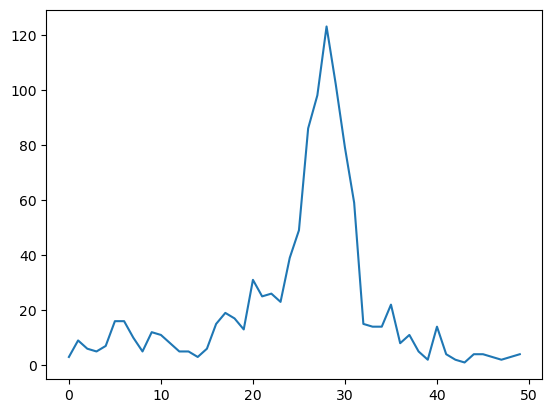

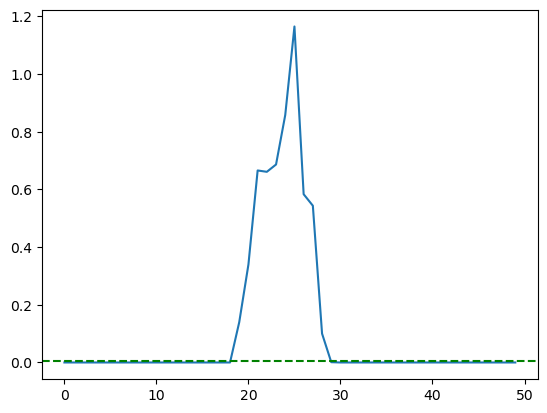

1063 1063
218.0


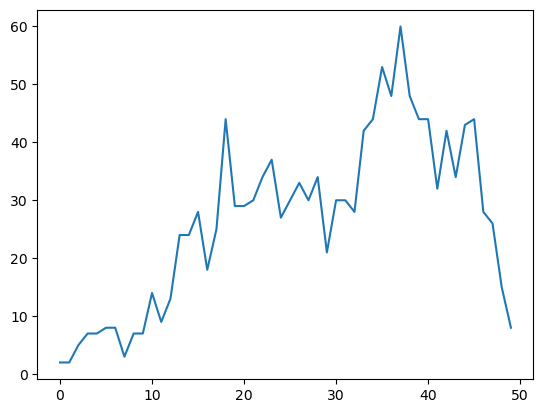

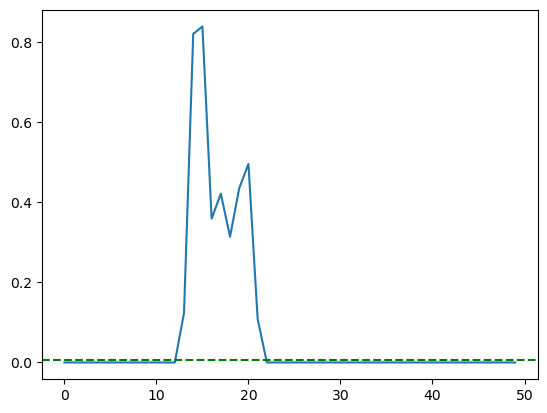

1332 1332
170.0


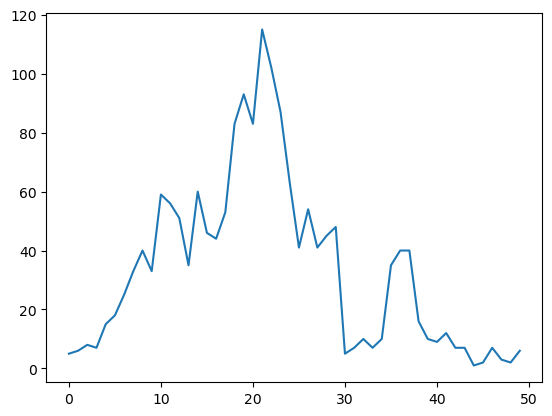

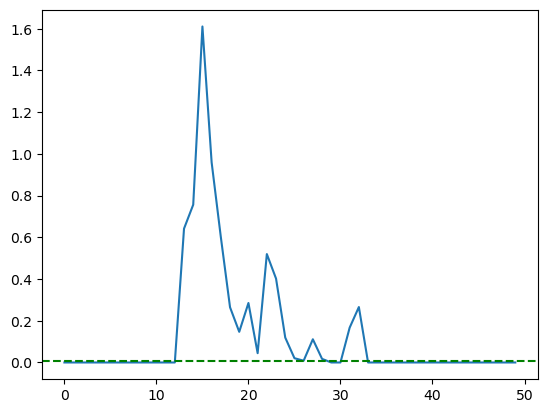

1685 1685



KeyboardInterrupt



In [118]:
directionGranularity = 4
directionVectors = genIcosahedron(directionGranularity)

densityField, densityFieldSpacing, densityFieldCorner = courseGrainField(data, defaultLatticeSize=128, returnSpacing=True, returnCorner=True)

linePoints = integratedHough3D(data, directionVectors,
                               densityField, densityFieldCorner, densityFieldSpacing,
                               latticeSize=128, neighborDistance=0.02,
                               lineJumpDistance=1, minPointsPerLine=5)

linePoints.shape

In [102]:
flattenedLinePoints = linePoints.reshape((len(linePoints)*2, 3))

lineSet = o3d.geometry.LineSet()
lineSet.points = o3d.utility.Vector3dVector(flattenedLinePoints)
lineSet.lines = o3d.utility.Vector2iVector([[i,i+1] for i in range(len(flattenedLinePoints))[::2]])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(data)

o3d.visualization.draw_geometries([lineSet, pcd])

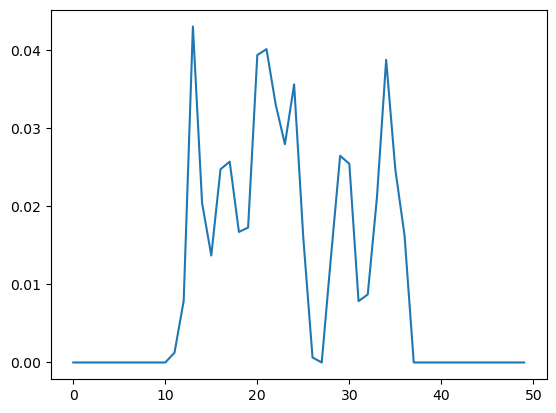

In [46]:
densityField, densityFieldSpacing, densityFieldCorner = courseGrainField(data, returnSpacing=True, returnCorner=True)

densityField = densityField.astype(np.float64)
i = 3

lineDirection = linePoints[i,1] - linePoints[i,0]

path = np.multiply.outer(np.linspace(-.5, 1.5, 50), lineDirection) + linePoints[i,0]
#path = np.multiply.outer(np.linspace(-.5, 1.5, 50), lineDirection) + np.random.uniform(-1/2, 1/2, size=3)

plt.plot(pathIntegralAlongField3D(densityField, path, densityFieldSpacing, densityFieldCorner))
plt.show()